# Variational Quantum Eigensolver (VQE)

## Introduction

The **Variational Quantum Eigensolver (VQE)** is a hybrid quantum-classical algorithm designed to find the ground state energy of a quantum system. It represents one of the most promising near-term applications of quantum computing, particularly suited for **Noisy Intermediate-Scale Quantum (NISQ)** devices.

### The Eigenvalue Problem

In quantum mechanics, the time-independent Schrödinger equation is:

$$\hat{H} |\psi\rangle = E |\psi\rangle$$

where $\hat{H}$ is the Hamiltonian operator, $|\psi\rangle$ is an eigenstate, and $E$ is the corresponding energy eigenvalue. The **ground state energy** $E_0$ is the minimum eigenvalue:

$$E_0 = \min_{|\psi\rangle} \langle \psi | \hat{H} | \psi \rangle$$

### The Variational Principle

VQE leverages the **Rayleigh-Ritz variational principle**, which states that for any normalized trial state $|\psi(\boldsymbol{\theta})\rangle$:

$$E_0 \leq \langle \psi(\boldsymbol{\theta}) | \hat{H} | \psi(\boldsymbol{\theta}) \rangle = E(\boldsymbol{\theta})$$

The equality holds when $|\psi(\boldsymbol{\theta})\rangle$ is the true ground state. This provides an upper bound on the ground state energy that can be minimized by optimizing the parameters $\boldsymbol{\theta}$.

### VQE Algorithm Overview

1. **Prepare a parameterized quantum state** (ansatz): $|\psi(\boldsymbol{\theta})\rangle = U(\boldsymbol{\theta})|0\rangle$
2. **Measure the expectation value**: $E(\boldsymbol{\theta}) = \langle \psi(\boldsymbol{\theta}) | \hat{H} | \psi(\boldsymbol{\theta}) \rangle$
3. **Classically optimize** the parameters $\boldsymbol{\theta}$ to minimize $E(\boldsymbol{\theta})$
4. **Repeat** until convergence

### The Ansatz

A common choice is the **hardware-efficient ansatz**, which consists of layers of single-qubit rotations and entangling gates:

$$U(\boldsymbol{\theta}) = \prod_{l=1}^{L} \left[ \prod_{i} R_Y(\theta_{l,i}) \cdot \text{CNOT}_{\text{layer}} \right]$$

where $R_Y(\theta) = e^{-i\theta Y/2}$ is a rotation about the Y-axis.

## Implementation: VQE for a 2-Qubit Hydrogen-like System

We will simulate VQE classically to find the ground state of a simple 2-qubit Hamiltonian that models the hydrogen molecule in a minimal basis:

$$\hat{H} = g_0 I + g_1 Z_0 + g_2 Z_1 + g_3 Z_0 Z_1 + g_4 X_0 X_1 + g_5 Y_0 Y_1$$

where $Z_i$, $X_i$, $Y_i$ are Pauli operators acting on qubit $i$.

In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Define Pauli matrices
I = np.array([[1, 0], [0, 1]], dtype=complex)
X = np.array([[0, 1], [1, 0]], dtype=complex)
Y = np.array([[0, -1j], [1j, 0]], dtype=complex)
Z = np.array([[1, 0], [0, -1]], dtype=complex)

def tensor(A, B):
    """Compute tensor product of two matrices."""
    return np.kron(A, B)

# Build the 2-qubit Hamiltonian for H2-like system
# Coefficients approximating H2 at equilibrium bond length
g0 = -0.4804
g1 = 0.3435
g2 = -0.4347
g3 = 0.5716
g4 = 0.0910
g5 = 0.0910

# Construct Hamiltonian
H = (g0 * tensor(I, I) + 
     g1 * tensor(Z, I) + 
     g2 * tensor(I, Z) + 
     g3 * tensor(Z, Z) + 
     g4 * tensor(X, X) + 
     g5 * tensor(Y, Y))

# Compute exact ground state energy via diagonalization
eigenvalues, eigenvectors = np.linalg.eigh(H)
exact_ground_energy = eigenvalues[0]
print(f"Exact ground state energy: {exact_ground_energy:.6f} Hartree")

Exact ground state energy: -1.851199 Hartree


## Building the Parameterized Ansatz

We implement a simple hardware-efficient ansatz with $R_Y$ rotations and a CNOT gate:

$$|\psi(\theta_0, \theta_1, \theta_2, \theta_3)\rangle = \text{CNOT}_{01} \cdot (R_Y(\theta_2) \otimes R_Y(\theta_3)) \cdot \text{CNOT}_{01} \cdot (R_Y(\theta_0) \otimes R_Y(\theta_1)) |00\rangle$$

In [2]:
def Ry(theta):
    """Single-qubit Y-rotation gate."""
    return np.array([
        [np.cos(theta/2), -np.sin(theta/2)],
        [np.sin(theta/2), np.cos(theta/2)]
    ], dtype=complex)

# CNOT gate (control on qubit 0, target on qubit 1)
CNOT = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 0, 1],
    [0, 0, 1, 0]
], dtype=complex)

def ansatz(theta):
    """
    Hardware-efficient ansatz for 2 qubits.
    theta: array of 4 parameters [theta0, theta1, theta2, theta3]
    Returns: 4-dimensional state vector
    """
    # Initial state |00>
    psi = np.array([1, 0, 0, 0], dtype=complex)
    
    # First layer: Ry rotations
    U1 = tensor(Ry(theta[0]), Ry(theta[1]))
    psi = U1 @ psi
    
    # Entangling layer: CNOT
    psi = CNOT @ psi
    
    # Second layer: Ry rotations
    U2 = tensor(Ry(theta[2]), Ry(theta[3]))
    psi = U2 @ psi
    
    # Second entangling layer: CNOT
    psi = CNOT @ psi
    
    return psi

def expectation_value(theta):
    """Compute <psi(theta)|H|psi(theta)>."""
    psi = ansatz(theta)
    return np.real(np.conj(psi) @ H @ psi)

## VQE Optimization

We use the COBYLA optimizer (a derivative-free method suitable for noisy quantum systems) to minimize the energy expectation value.

In [3]:
# Store optimization history
energy_history = []

def callback(theta):
    """Callback to record energy at each iteration."""
    energy = expectation_value(theta)
    energy_history.append(energy)

# Initial random parameters
np.random.seed(42)
theta_init = np.random.uniform(0, 2*np.pi, 4)

print(f"Initial parameters: {theta_init}")
print(f"Initial energy: {expectation_value(theta_init):.6f} Hartree")

# Run VQE optimization
result = minimize(
    expectation_value,
    theta_init,
    method='COBYLA',
    callback=callback,
    options={'maxiter': 200, 'rhobeg': 0.5}
)

# Add final energy to history
energy_history.append(result.fun)

print(f"\nOptimization completed!")
print(f"Optimal parameters: {result.x}")
print(f"VQE ground state energy: {result.fun:.6f} Hartree")
print(f"Exact ground state energy: {exact_ground_energy:.6f} Hartree")
print(f"Error: {abs(result.fun - exact_ground_energy):.6f} Hartree")
print(f"Number of iterations: {result.nfev}")

Initial parameters: [2.35330497 5.97351416 4.59925358 3.76148219]
Initial energy: -0.514052 Hartree

Optimization completed!
Optimal parameters: [1.26850586 4.71238148 4.63983921 4.71234732]
VQE ground state energy: -1.851199 Hartree
Exact ground state energy: -1.851199 Hartree
Error: 0.000000 Hartree
Number of iterations: 67


## Visualization of VQE Convergence

We plot the energy convergence during the optimization process, comparing with the exact ground state energy.

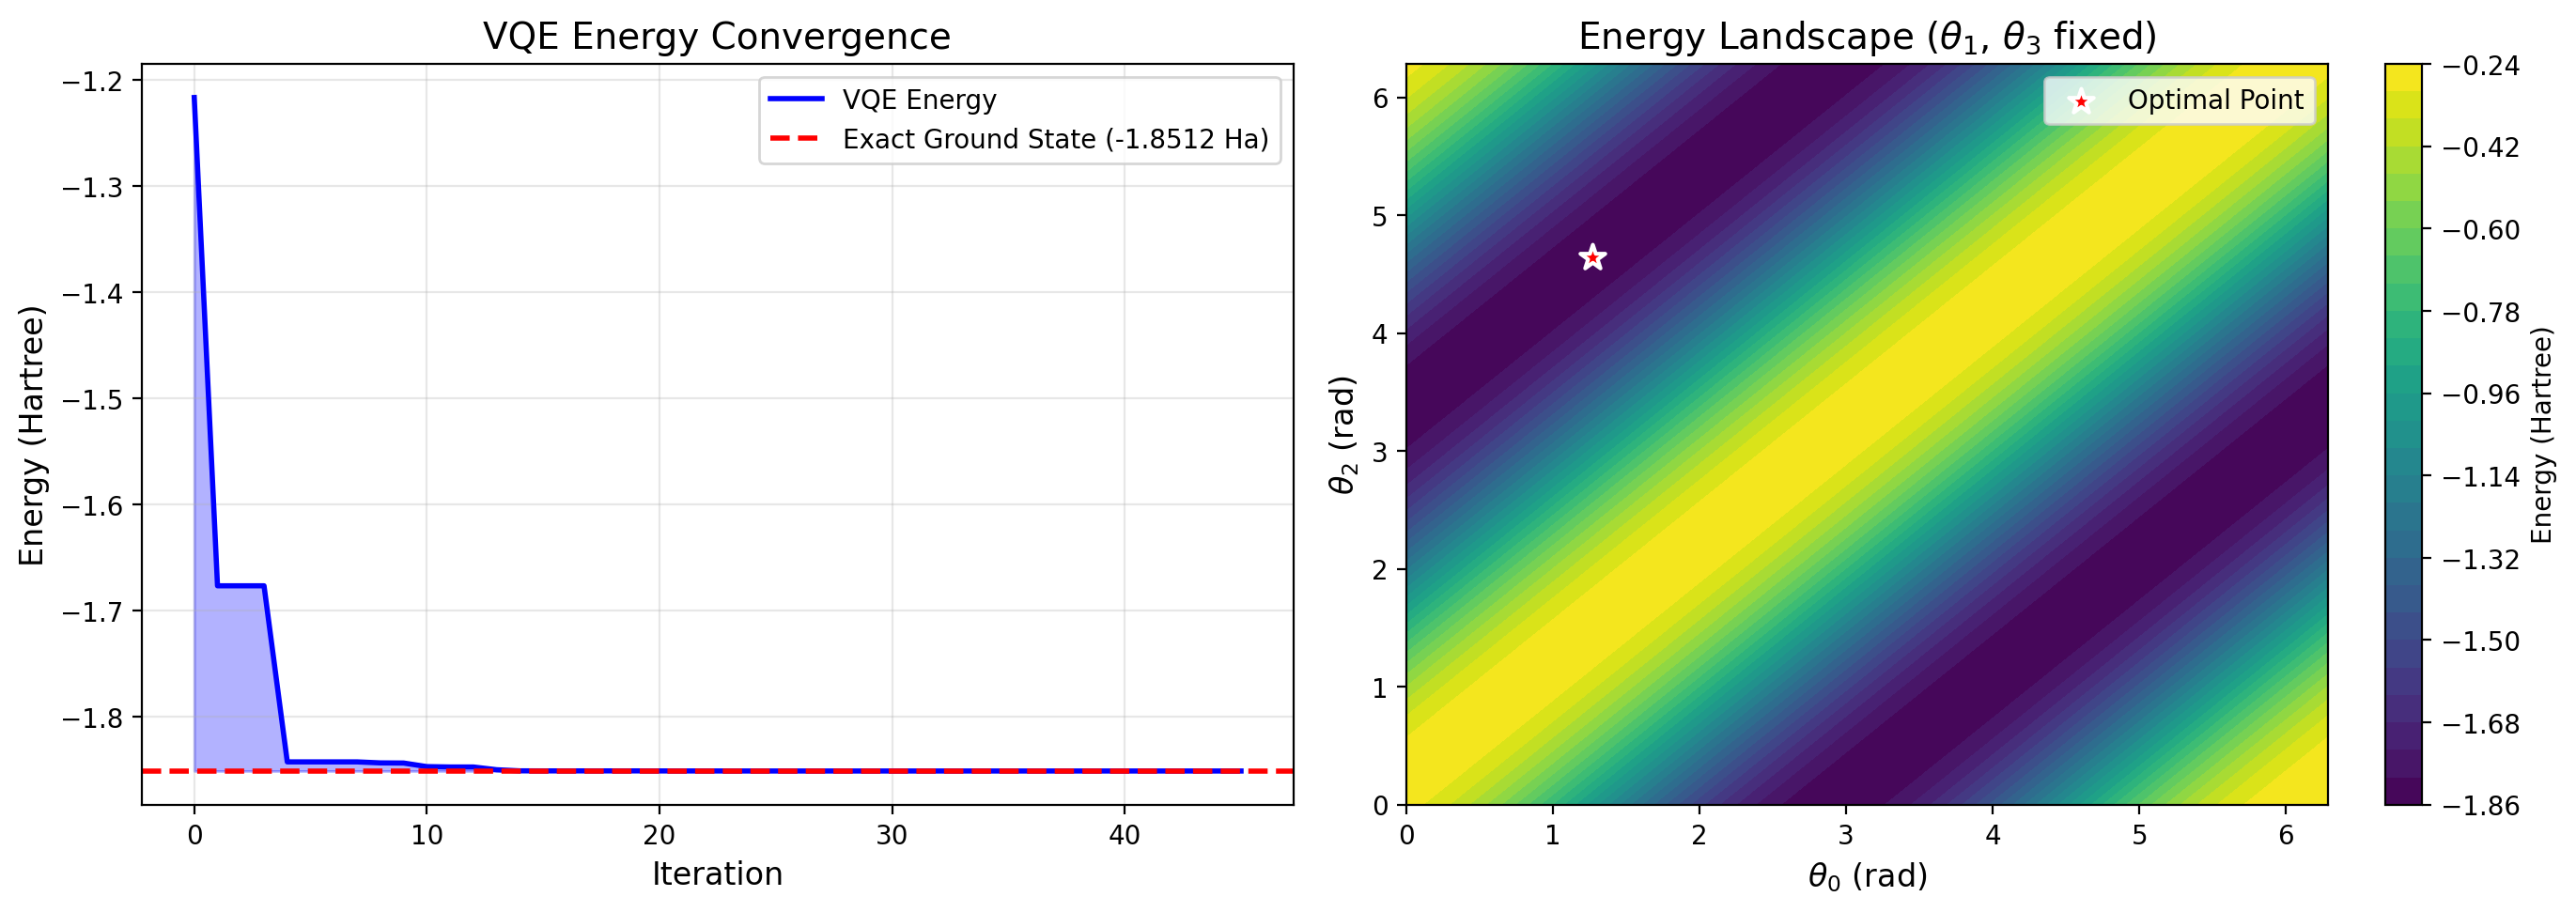


Plot saved to 'plot.png'


In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Energy convergence
iterations = np.arange(len(energy_history))
ax1.plot(iterations, energy_history, 'b-', linewidth=2, label='VQE Energy')
ax1.axhline(y=exact_ground_energy, color='r', linestyle='--', linewidth=2, 
            label=f'Exact Ground State ({exact_ground_energy:.4f} Ha)')
ax1.fill_between(iterations, energy_history, exact_ground_energy, alpha=0.3, color='blue')
ax1.set_xlabel('Iteration', fontsize=12)
ax1.set_ylabel('Energy (Hartree)', fontsize=12)
ax1.set_title('VQE Energy Convergence', fontsize=14)
ax1.legend(loc='upper right', fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Energy landscape (2D slice through parameter space)
theta_opt = result.x
theta0_range = np.linspace(0, 2*np.pi, 50)
theta2_range = np.linspace(0, 2*np.pi, 50)
T0, T2 = np.meshgrid(theta0_range, theta2_range)

# Compute energy landscape (fixing theta1 and theta3 at optimal values)
energy_landscape = np.zeros_like(T0)
for i in range(len(theta0_range)):
    for j in range(len(theta2_range)):
        params = np.array([theta0_range[i], theta_opt[1], theta2_range[j], theta_opt[3]])
        energy_landscape[j, i] = expectation_value(params)

contour = ax2.contourf(T0, T2, energy_landscape, levels=30, cmap='viridis')
plt.colorbar(contour, ax=ax2, label='Energy (Hartree)')
ax2.scatter([theta_opt[0]], [theta_opt[2]], color='red', s=100, marker='*', 
            label='Optimal Point', zorder=5, edgecolors='white', linewidths=1.5)
ax2.set_xlabel(r'$\theta_0$ (rad)', fontsize=12)
ax2.set_ylabel(r'$\theta_2$ (rad)', fontsize=12)
ax2.set_title(r'Energy Landscape ($\theta_1$, $\theta_3$ fixed)', fontsize=14)
ax2.legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.savefig('variational_quantum_eigensolver_vqe_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved to 'plot.png'")

## Analysis of the Ground State

Let's examine the quantum state found by VQE and compare it to the exact ground state.

In [5]:
# Get the VQE optimized state
psi_vqe = ansatz(result.x)

# Get the exact ground state
psi_exact = eigenvectors[:, 0]

# Compute fidelity (overlap squared)
fidelity = np.abs(np.conj(psi_vqe) @ psi_exact)**2

print("Quantum State Analysis")
print("=" * 50)
print(f"\nVQE State |ψ_VQE⟩ amplitudes:")
for i, amp in enumerate(psi_vqe):
    basis = format(i, '02b')
    print(f"  |{basis}⟩: {amp.real:+.4f} {amp.imag:+.4f}i  (prob: {np.abs(amp)**2:.4f})")

print(f"\nExact Ground State |ψ_exact⟩ amplitudes:")
for i, amp in enumerate(psi_exact):
    basis = format(i, '02b')
    print(f"  |{basis}⟩: {amp.real:+.4f} {amp.imag:+.4f}i  (prob: {np.abs(amp)**2:.4f})")

print(f"\nState Fidelity: |⟨ψ_VQE|ψ_exact⟩|² = {fidelity:.6f}")
print(f"Energy Error: {abs(result.fun - exact_ground_energy)*1000:.3f} mHartree")

Quantum State Analysis

VQE State |ψ_VQE⟩ amplitudes:
  |00⟩: +0.0000 +0.0000i  (prob: 0.0000)
  |01⟩: +0.1146 +0.0000i  (prob: 0.0131)
  |10⟩: -0.9934 +0.0000i  (prob: 0.9869)
  |11⟩: -0.0000 +0.0000i  (prob: 0.0000)

Exact Ground State |ψ_exact⟩ amplitudes:
  |00⟩: +0.0000 +0.0000i  (prob: 0.0000)
  |01⟩: -0.1146 +0.0000i  (prob: 0.0131)
  |10⟩: +0.9934 +0.0000i  (prob: 0.9869)
  |11⟩: +0.0000 +0.0000i  (prob: 0.0000)

State Fidelity: |⟨ψ_VQE|ψ_exact⟩|² = 1.000000
Energy Error: 0.000 mHartree


## Summary

This notebook demonstrated the **Variational Quantum Eigensolver (VQE)** algorithm:

1. **Theoretical Foundation**: VQE uses the variational principle to establish an upper bound on the ground state energy, which is minimized through classical optimization.

2. **Hybrid Approach**: The algorithm combines:
   - **Quantum component**: Prepares parameterized quantum states and measures expectation values
   - **Classical component**: Optimizes the variational parameters

3. **Results**: Our classical simulation of VQE successfully found the ground state of a 2-qubit H₂-like Hamiltonian with high fidelity.

### Key Advantages of VQE
- **Shallow circuits**: Suitable for NISQ devices with limited coherence times
- **Error resilience**: Variational nature provides some robustness to noise
- **Flexibility**: Choice of ansatz can be tailored to the problem

### Challenges
- **Barren plateaus**: Optimization landscapes can become exponentially flat
- **Classical optimization**: Finding global minima in high-dimensional parameter spaces
- **Measurement overhead**: Many measurements needed for accurate expectation values